## Installing Packages

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM, GRU
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import math
from sklearn.metrics import mean_squared_error
from kerastuner.engine.hyperparameters import HyperParameters
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch
import seaborn as sns
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
%matplotlib inline

C:\Users\prakh\AppData\Local\Temp\ipykernel_15932\421942938.py:10: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.engine.hyperparameters import HyperParameters


## Spliting Data as Train and Test

In [2]:
df_test = pd.read_csv('Google_Stock_Test (2023).csv')
df_train = pd.read_csv('Google_Stock_Train (2010-2022).csv')
df = pd.concat([df_train,df_test])

In [3]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,15.689439,15.753504,15.621622,15.684434,15.684434,78169752
1,2010-01-05,15.695195,15.711712,15.554054,15.615365,15.615365,120067812
2,2010-01-06,15.662162,15.662162,15.174174,15.221722,15.221722,158988852
3,2010-01-07,15.250250,15.265265,14.831081,14.867367,14.867367,256315428
4,2010-01-08,14.814815,15.096346,14.742492,15.065566,15.065566,188783028


## Data Preprocessing

In [4]:
df.info() # to check for data summary 

<class 'pandas.core.frame.DataFrame'>
Index: 3415 entries, 0 to 142
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       3415 non-null   object 
 1   Open       3415 non-null   float64
 2   High       3415 non-null   float64
 3   Low        3415 non-null   float64
 4   Close      3415 non-null   float64
 5   Adj Close  3415 non-null   float64
 6   Volume     3415 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 213.4+ KB


In [5]:
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3415.000000,3415.000000,3415.000000,3415.000000,3415.000000,3.415000e+03
mean,51.602449,52.137050,51.069382,51.615610,51.615610,5.919210e+07
std,37.037725,37.483882,36.606707,37.050992,37.050992,4.883960e+07
min,10.968719,11.068068,10.851602,10.912663,10.912663,9.312000e+06
25%,21.630881,21.804179,21.442317,21.660035,21.660035,2.889500e+07
50%,40.091499,40.338001,39.844002,40.132000,40.132000,4.033400e+07
75%,67.845249,68.434250,67.299999,67.783249,67.783249,7.784608e+07
max,151.250000,151.546494,148.899002,149.838501,149.838501,5.923990e+08


In [6]:
df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [7]:
df.shape

(3415, 7)

In [8]:
df.isnull().sum() #to check for null values

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [9]:
df.dtypes

Date          object
Open         float64
High         float64
Low          float64
Close        float64
Adj Close    float64
Volume         int64
dtype: object

In [10]:
df    = df.loc[:,["Open"]].values
train = df[:len(df)-50] 
test = df[len(train):] 
# reshape
train = train.reshape(train.shape[0],1)


In [11]:
train.shape

(3365, 1)

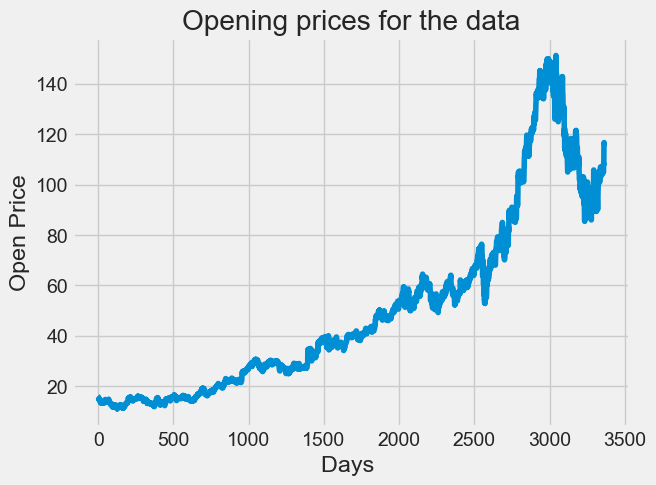

In [12]:
plt.plot(train);
plt.title("Opening prices for the data");
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.show()

## Normalization / Feature Scaling

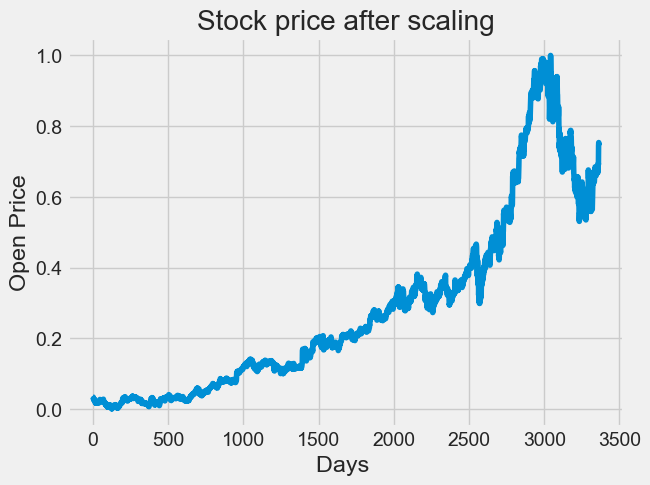

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range= (0,1)) # defining of Scaler
train_scaled = scaler.fit_transform(train) # applying to Scaler to train
plt.plot(train_scaled)
plt.xlabel("Days ")
plt.ylabel("Open Price")
plt.title("Stock price after scaling")
plt.show()

## Creating X_train and y_train from scaled Train data

In [14]:
# We add first 50 timesteps to "X_train" and  51 timesteps to "y_train" .
X_train = []
y_train = []
timesteps = 50

for i in range(timesteps, train_scaled.shape[0]):
    X_train.append(train_scaled[i-timesteps:i,0])
    y_train.append(train_scaled[i,0])

X_train, y_train = np.array(X_train), np.array(y_train)


# Reshaping
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)  # Dimension of array is 3.

## Creating RNN model 

In [15]:
# --- RNN ---

# Importing the Keras libraries and packages

from keras.models import Sequential  
from keras.layers import Dense 
from keras.layers import SimpleRNN
from keras.layers import Dropout # it block to overfitting 

# Initialising the RNN
regressor = Sequential()

# Adding the first RNN layer and some Dropout regularisation
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True, input_shape = (X_train.shape[1], 1)))
regressor.add(Dropout(0.2)) 

# Adding a second RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a third RNN layer and some Dropout regularisation. 
regressor.add(SimpleRNN(units = 50,activation='tanh', return_sequences = True))
regressor.add(Dropout(0.2))

# Adding a fourth RNN layer and some Dropout regularisation.
regressor.add(SimpleRNN(units = 50))
regressor.add(Dropout(0.2))


# Adding the output layer
regressor.add(Dense(units = 1))

# Compiling the RNN
regressor.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
Rnn_history = regressor.fit(X_train, y_train, epochs = 100, batch_size = 32)

Epoch 1/100


c:\Users\prakh\Desktop\Deep Learning\Assignment 3\Stock-Price-Prediction-using-RNN\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


104/104 ━━━━━━━━━━━━━━━━━━━━ 12s 31ms/step - loss: 0.3447
Epoch 2/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - loss: 0.1108
Epoch 3/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0463
Epoch 4/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 35ms/step - loss: 0.0316
Epoch 5/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 37ms/step - loss: 0.0194
Epoch 6/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - loss: 0.0144
Epoch 7/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - loss: 0.0115
Epoch 8/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.0093
Epoch 9/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - loss: 0.0080
Epoch 10/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0064
Epoch 11/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0057
Epoch 12/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - loss: 0.0049
Epoch 13/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0048
Epoch 14/100
104/104 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0043
Epoch 15/100
104/104 ━━━━━━━━━━━━━━━━━━━

## Evaluating Model

In [16]:
# Losses
Rnn_history.history["loss"]

[0.24008597433567047,
 0.08719407767057419,
 0.04170561209321022,
 0.02705279551446438,
 0.018650127574801445,
 0.014033053070306778,
 0.011136260814964771,
 0.009145285934209824,
 0.008000886999070644,
 0.006361737847328186,
 0.005779303144663572,
 0.004678485449403524,
 0.00472337007522583,
 0.004015418700873852,
 0.0038623951841145754,
 0.00331456889398396,
 0.0030985039193183184,
 0.002789614489302039,
 0.002687607193365693,
 0.0024346255231648684,
 0.0024216247256845236,
 0.002490368904545903,
 0.0023376743774861097,
 0.0024596198927611113,
 0.0019530218560248613,
 0.0018996362341567874,
 0.001574161695316434,
 0.0017097326926887035,
 0.001526237465441227,
 0.0016044501680880785,
 0.0015327121363952756,
 0.0016522902296856046,
 0.0012522557517513633,
 0.001444625435397029,
 0.0013711954234167933,
 0.0014183659804984927,
 0.0013444944052025676,
 0.0013143359683454037,
 0.001253473456017673,
 0.0012498956639319658,
 0.0010663123102858663,
 0.001282360521145165,
 0.001129603479057550

In [17]:
min_loss = np.min(Rnn_history.history["loss"])
RMSE = math.sqrt(min_loss)
RMSE

0.027407301976235917

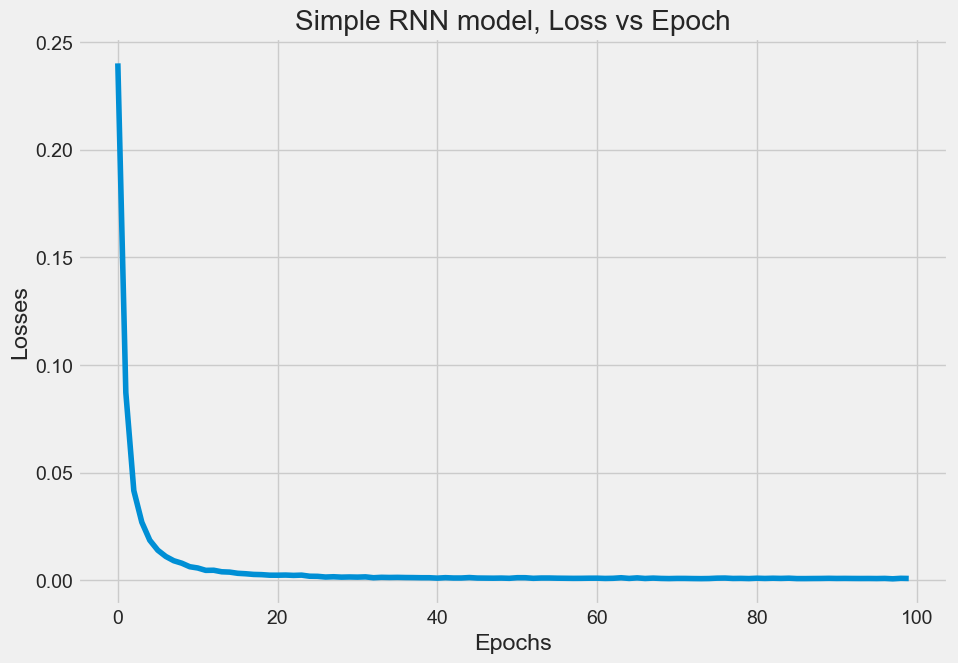

In [18]:
# Plotting Loss vs Epochs
plt.figure(figsize =(10,7))
plt.plot(Rnn_history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("Simple RNN model, Loss vs Epoch")
plt.show()

In [19]:
inputs = df[len(df) - len(test) - timesteps:]
inputs = scaler.transform(inputs)  # min max scaler

In [20]:
X_test = []
for i in range(timesteps, inputs.shape[0]):
    X_test.append(inputs[i-timesteps:i, 0]) # We get 50 elements by shifting from 0 to 50 and from 1 to 51. 
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

## Model predictions for train data 

In [21]:
predicted_data = regressor.predict(X_test)
predicted_data = scaler.inverse_transform(predicted_data)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 247ms/step


In [22]:
rmse = np.sqrt(np.mean(((predicted_data - test) ** 2)))
rmse

np.float64(5.753821032399576)

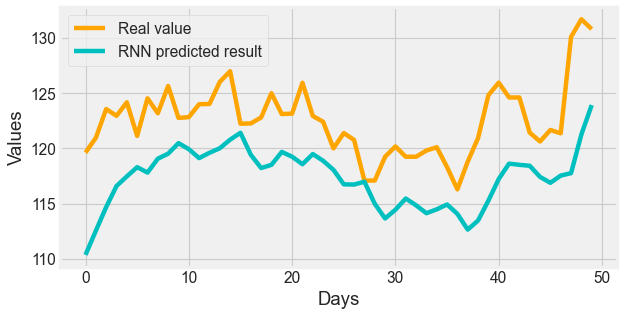

In [23]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="orange",label="Real value")
plt.plot(predicted_data,color="c",label="RNN predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Creating LSTM Model

In [24]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [25]:
model = Sequential()
model.add(LSTM(10, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='Adam')
history=model.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50


c:\Users\prakh\Desktop\Deep Learning\Assignment 3\Stock-Price-Prediction-using-RNN\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 0.0210
Epoch 2/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.9552e-04
Epoch 3/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 2.1755e-04
Epoch 4/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.8221e-04
Epoch 5/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.4803e-04
Epoch 6/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.4013e-04
Epoch 7/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 1.2819e-04
Epoch 8/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - loss: 9.9249e-05
Epoch 9/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.0849e-05
Epoch 10/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.8045e-05
Epoch 11/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.1068e-04
Epoch 12/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.5630e-05
Epoch 13/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.1080e-04
Epoch 14/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3m

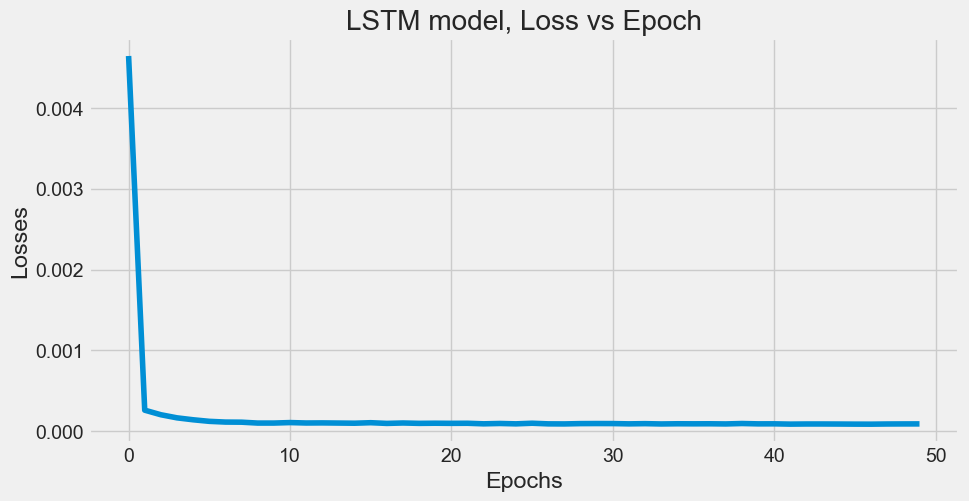

In [26]:
plt.figure(figsize =(10,5))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM model, Loss vs Epoch")
plt.show()

## Model predictions

In [27]:
predicted_data2=model.predict(X_test)
predicted_data2=scaler.inverse_transform(predicted_data2)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step


In [28]:
min_loss = np.min(history.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.009318216613923465

In [29]:
rmse = np.sqrt(np.mean(((predicted_data2 - test) ** 2)))
rmse

np.float64(2.858000750901173)

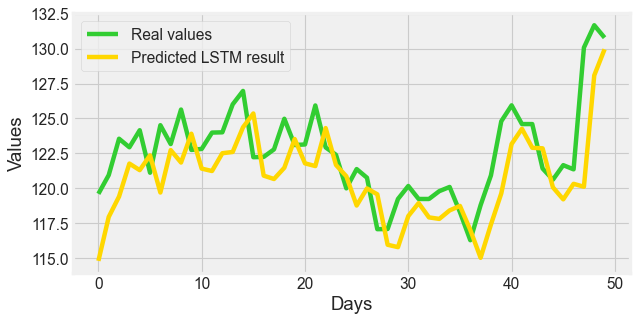

In [30]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="LimeGreen",label="Real values")
plt.plot(predicted_data2,color="Gold",label="Predicted LSTM result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Creating GRU Model

In [31]:
model = Sequential()
model.add(GRU(20, input_shape=(None,1)))
model.add(Dense(1))
model.compile(loss="mean_squared_error",optimizer='Adam')
history=model.fit(X_train,y_train,epochs=50, batch_size=1)

Epoch 1/50


c:\Users\prakh\Desktop\Deep Learning\Assignment 3\Stock-Price-Prediction-using-RNN\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step - loss: 0.0037
Epoch 2/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.7667e-04
Epoch 3/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.3691e-04
Epoch 4/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.1073e-04
Epoch 5/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.2783e-04
Epoch 6/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.0658e-04
Epoch 7/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.0950e-04
Epoch 8/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.1213e-04
Epoch 9/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 9.7273e-05
Epoch 10/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.1609e-04
Epoch 11/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 1.1103e-04
Epoch 12/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.0832e-04
Epoch 13/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - loss: 1.0629e-04
Epoch 14/50
3315/3315 ━━━━━━━━━━━━━━━━━━━━ 11s 3m

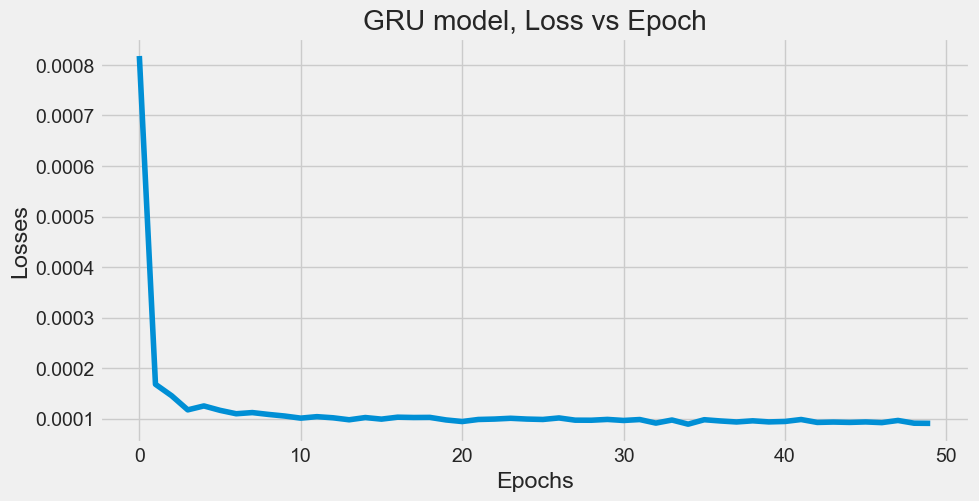

In [32]:
plt.figure(figsize =(10,5))
plt.plot(history.history["loss"])
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("GRU model, Loss vs Epoch")
plt.show()

In [33]:
predicted_data3=model.predict(X_test)
predicted_data3=scaler.inverse_transform(predicted_data3)

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/stepWARNING:tensorflow:6 out of the last 6 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x00000234C5C5FD80> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [34]:
min_loss = np.min(history.history['loss'])
RMSE = math.sqrt(min_loss)
RMSE

0.009444629609401

In [35]:
rmse = np.sqrt(np.mean(((predicted_data2 - test) ** 2)))
rmse

np.float64(2.858000750901173)

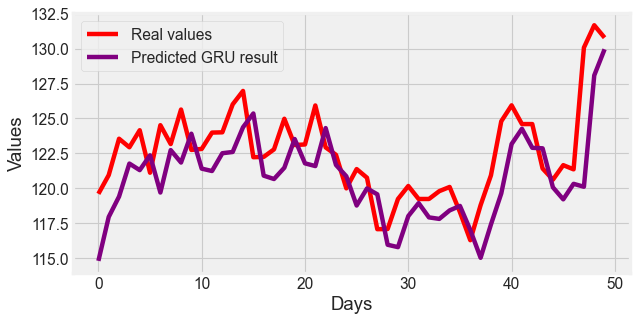

In [36]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="red",label="Real values")
plt.plot(predicted_data2,color="Purple",label="Predicted GRU result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Values")
plt.grid(True)
plt.show()

## Comparetive Study of RNN predictions and LSTM predictions

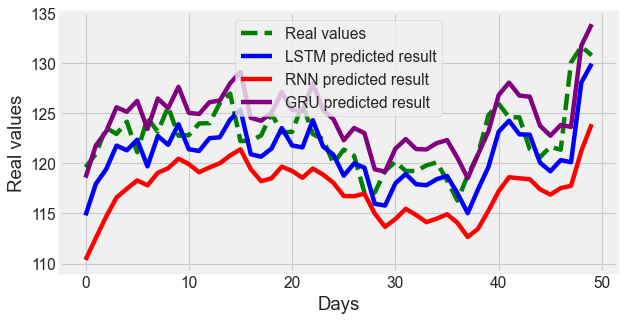

In [37]:
plt.figure(figsize=(8,4), dpi=80, facecolor='w', edgecolor='k')
plt.plot(test,color="green", linestyle='dashed',label="Real values")
plt.plot(predicted_data2,color="blue", label="LSTM predicted result")
plt.plot(predicted_data,color="red",label="RNN predicted result") #
plt.plot(predicted_data3,color="purple", label="GRU predicted result")
plt.legend()
plt.xlabel("Days")
plt.ylabel("Real values")
plt.grid(True)
plt.show()